In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

# **Image Captioning**



In [2]:
image_path = '/content/drive/MyDrive/IR_project/flickr8k/Images'

In [3]:
data = pd.read_csv('/content/drive/MyDrive/IR_project/flickr8k/captions.txt')
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [4]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.

    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"../input/flickr8k/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

# **Visualization**
- Images and their corresponding captions

In [ ]:
display_images(data.sample(15))

# **Caption Text Preprocessing Steps**
- Convert sentences into lowercase
- Remove special characters and numbers present in the text
- Remove extra spaces
- Remove single characters
- Add a starting and an ending tag to the sentences to indicate the beginning and the ending of a sentence

<img src='http://zjpnrm2br14wspo448nls17u-wpengine.netdna-ssl.com/wp-content/uploads/2020/09/processing-steps.png' >

In [5]:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "startseq "+data['caption']+" endseq"
    return data

## __Preprocessed Text__

In [6]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

## __Tokenization and Encoded Representation__


In [7]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[1, 18, 315, 63, 195, 116, 2]

# **Image Feature Extraction**


In [ ]:
import pickle
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

features_path = '/content/drive/MyDrive/IR_project/flickr8k/image_features.pkl'

# Save features to a file
with open(features_path, 'wb') as file:
    pickle.dump(features, file)

100%|██████████| 8091/8091 [49:25<00:00,  2.73it/s]


# **Data Generation**
- Since Image Caption model training like any other neural network training is a highly resource utillizing process we cannot load the data into the main memory all at once, and hence we need to generate the data in the required format batch wise
- The inputs will be the image embeddings and their corresonding caption text embeddings for the training process
- The text embeddings are passed word by word for the caption generation during inference time

In [18]:
from tensorflow.keras.utils import Sequence, to_categorical
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences


class CustomDataGenerator(Sequence):
    def __init__(self, df, features, tokenizer, batch_size, vocab_size, max_length, shuffle=True):
        self.df = df.copy()
        self.features = features
        self.tokenizer = tokenizer
        self.batch_size = batch_size
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.shuffle = shuffle
        self.indices = np.arange(len(self.df))
        if shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __getitem__(self, index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        batch = self.df.iloc[indices]
        X1, X2, y = [], [], []
        for _, row in batch.iterrows():
            image_id, caption = row['image'], row['caption']
            feature = self.features[image_id][0]
            seq = self.tokenizer.texts_to_sequences([caption])[0]
            for i in range(1, len(seq)):
                in_seq, out_seq = seq[:i], seq[i]
                in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                out_seq = np.zeros((self.vocab_size,))
                out_seq[out_seq] = 1
                X1.append(feature)
                X2.append(in_seq)
                y.append(out_seq)
        return [np.array(X1), np.array(X2)], np.array(y)


# **Modelling**
- The image embedding representations are concatenated with the first word of sentence ie. starseq and passed to the LSTM network
- The LSTM network starts generating words after each input thus forming a sentence at the end

In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, GRU, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import pickle

# Assuming vocab_size and image_path are defined
# Load pre-processed features
features_path = '/content/drive/MyDrive/IR_project/flickr8k/image_features.pkl'
with open(features_path, 'rb') as file:
    features = pickle.load(file)

# Assuming captions is a list or dictionary of all captions
max_length = max(len(caption.split()) for caption in captions)

# Model definition
input1 = Input(shape=(1920,))  # Adjust this to match the size of your actual features
input2 = Input(shape=(max_length,))

# Continue with your model definition as before
img_features = Dense(256, activation='relu')(input1)
img_features = Dropout(0.5)(img_features)

sentence_features = Embedding(input_dim=vocab_size, output_dim=256, mask_zero=True)(input2)
sentence_features = GRU(128)(sentence_features)
sentence_features = Dropout(0.5)(sentence_features)

combined_features = Dense(256, activation='relu')(sentence_features)
x = Dropout(0.5)(combined_features)
x = Dense(128, activation='relu')(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1, input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.utils import plot_model

## **Model Modification**
- A slight change has been made in the original model architecture to push the performance. The image feature embeddings are added to the output of the LSTMs and then passed on to the fully connected layers
- This slightly improves the performance of the model orignally proposed back in 2014: __Show and Tell: A Neural Image Caption Generator__ (https://arxiv.org/pdf/1411.4555.pdf)

In [ ]:
plot_model(caption_model)

In [ ]:
caption_model.summary()

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

# Assuming 'data' is your DataFrame and 'captions' is a list of all captions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)

# Instead of using a percentage, explicitly select 1500 for training and the rest for validation/testing
train_images, val_images = train_test_split(images, train_size=1500, test_size=100, random_state=42)

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)

# Make sure to adjust the features dictionary
with open(features_path, 'rb') as file:
    all_features = pickle.load(file)

# Filter the features to include only those in the train and test sets
train_features = {img: all_features[img] for img in train_images if img in all_features}
test_features = {img: all_features[img] for img in val_images if img in all_features}

# Now initialize your data generators with the filtered features and adjusted datasets
train_generator = CustomDataGenerator(df=train, X_col='image', y_col='caption', batch_size=32, directory=image_path,
                                      tokenizer=tokenizer, vocab_size=vocab_size, max_length=max_length, features=train_features)

validation_generator = CustomDataGenerator(df=test, X_col='image', y_col='caption', batch_size=32, directory=image_path,
                                           tokenizer=tokenizer, vocab_size=vocab_size, max_length=max_length, features=test_features)



In [11]:
model_name = "model_optimized_new.h5"
checkpoint = ModelCheckpoint(model_name, monitor="val_loss", mode="min", save_best_only = True, verbose=1)
earlystopping = EarlyStopping(monitor='val_loss', min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.2, min_lr=0.00000001)


In [12]:
history = caption_model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[checkpoint, earlystopping, learning_rate_reduction],
    use_multiprocessing=True,
    workers=8  # Adjust based on your system's capabilities
)

Epoch 1/20
234/234 [==============================] - ETA: 0s - loss: 6.0919 - accuracy: 0.0982
Epoch 1: val_loss improved from inf to 5.44795, saving model to model_optimized_new.h5
234/234 [==============================] - 680s 3s/step - loss: 6.0919 - accuracy: 0.0982 - val_loss: 5.4480 - val_accuracy: 0.1297 - lr: 0.0010
Epoch 2/20
234/234 [==============================] - ETA: 0s - loss: 5.1208 - accuracy: 0.1580
Epoch 2: val_loss improved from 5.44795 to 4.86301, saving model to model_optimized_new.h5
234/234 [==============================] - 146s 611ms/step - loss: 5.1208 - accuracy: 0.1580 - val_loss: 4.8630 - val_accuracy: 0.1992 - lr: 0.0010
Epoch 3/20
234/234 [==============================] - ETA: 0s - loss: 4.6999 - accuracy: 0.1963
Epoch 3: val_loss improved from 4.86301 to 4.68548, saving model to model_optimized_new.h5
234/234 [==============================] - 149s 625ms/step - loss: 4.6999 - accuracy: 0.1963 - val_loss: 4.6855 - val_accuracy: 0.2190 - lr: 0.0010
Ep

# **Inference**
- Learning Curve (Loss Curve)
- Assessment of Generated Captions (by checking the relevance of the caption with respect to the image, BLEU Score will not be used in this kernel)

## **Learning Curve**
- The model has clearly overfit, possibly due to less amount of data
- We can tackle this problem in two ways
    1. Train the model on a larger dataset Flickr40k
    2. Attention Models

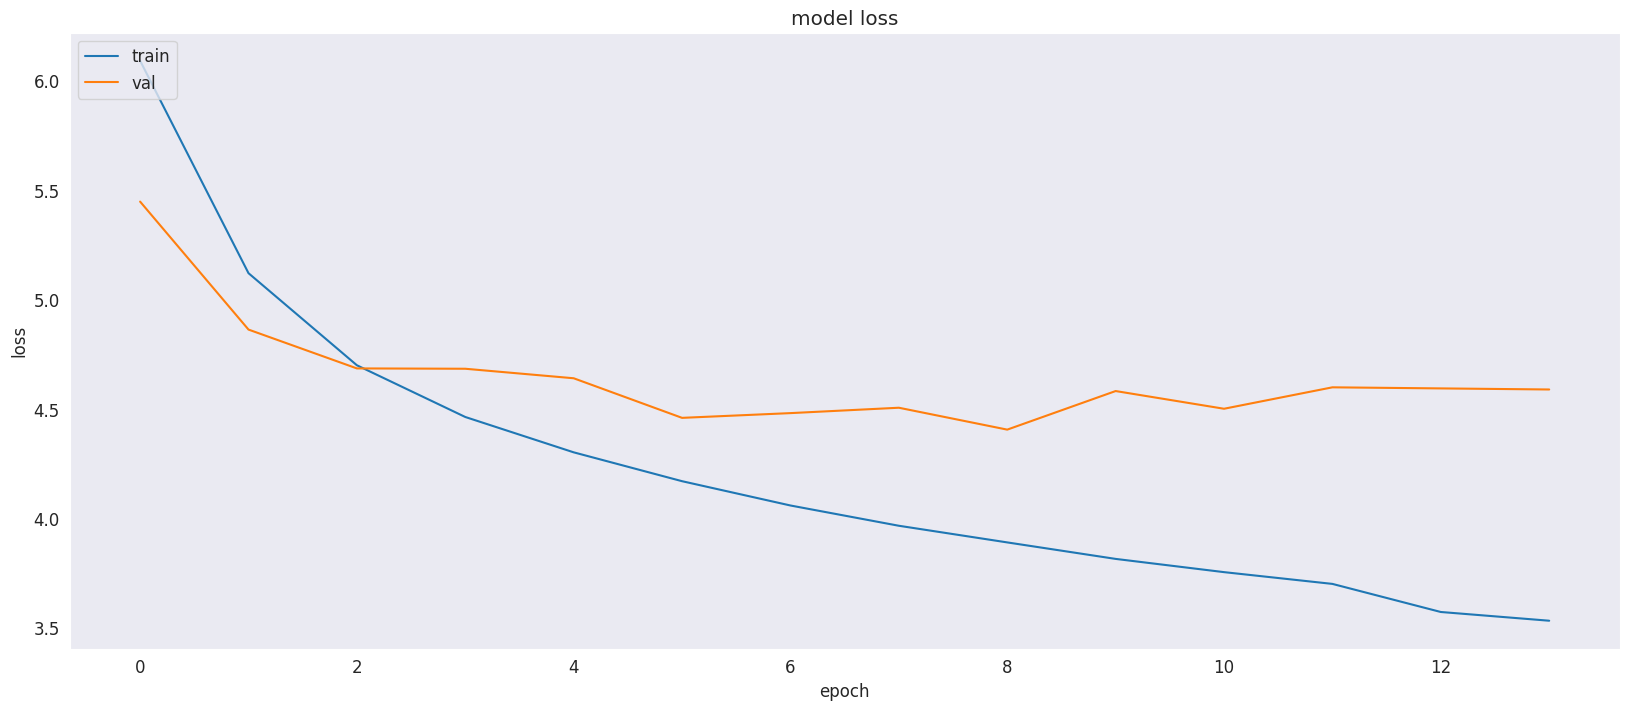

In [13]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## **Caption Generation Utility Functions**
- Utility functions to generate the captions of input images at the inference time.
- Here the image embeddings are passed along with the first word, followed by which the text embedding of each new word is passed to generate the next word

In [14]:
def idx_to_word(integer,tokenizer):

    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [15]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import os
from nltk.translate.bleu_score import corpus_bleu
import random

def predict_caption(model, image, tokenizer, max_length, features):
    # Reshape feature for the model
    feature = features[image].reshape((1, -1))  # Use -1 to automatically adjust to the correct size
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        y_pred = model.predict([feature, sequence], verbose=0)
        y_pred = np.argmax(y_pred)
        word = tokenizer.index_word.get(y_pred, None)
        if word is None or word == 'endseq':
            break
        in_text += ' ' + word
    return in_text



## **Taking 10 Random Samples for Caption Prediction**

In [16]:
# Ensure 'test' is your DataFrame containing the test dataset
samples = test.sample(n=10, random_state=42).reset_index(drop=True)

actual, predicted = [], []
for index, record in samples.iterrows():
    # Generate caption
    caption_pred = predict_caption(caption_model, record['image'], tokenizer, max_length, features)
    samples.loc[index, 'predicted_caption'] = caption_pred

    # Prepare actual and predicted captions for BLEU score calculation
    actual.append([record['caption'].split()])
    predicted.append(caption_pred.split())

# Display the generated captions alongside the images
for index, row in samples.iterrows():
    print(f"Image: {row['image']}, Predicted Caption: {row['predicted_caption']}")


Image: 3364160101_c5e6c52b25.jpg, Predicted Caption: startseq two people are playing in the air
Image: 2314722788_6262c3aa40.jpg, Predicted Caption: startseq two people are playing in the air
Image: 3373946160_1c82d54442.jpg, Predicted Caption: startseq two people are playing in the air
Image: 278002800_3817135105.jpg, Predicted Caption: startseq two people are playing in the air
Image: 2521770311_3086ca90de.jpg, Predicted Caption: startseq two people are playing in the air
Image: 3443703471_14845d8850.jpg, Predicted Caption: startseq two people are playing in the air
Image: 3396036947_0af6c3aab7.jpg, Predicted Caption: startseq two people are playing in the air
Image: 2644916196_16f91dae54.jpg, Predicted Caption: startseq two people are playing in the air
Image: 2271468944_3264d29208.jpg, Predicted Caption: startseq two people are playing in the air
Image: 3700004668_99c3e3f55b.jpg, Predicted Caption: startseq two people are playing in the air


In [17]:
print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0)))
print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))


BLEU-1: 0.168781
BLEU-2: 0.060145
BLEU-3: 0.000000
BLEU-4: 0.000000


# **Results**
- As we can clearly see there is some redundant caption generation e.g. Dog running through the water, overusage of blue shirt for any other coloured cloth
- The model performance can be further improved by training on more data and using attention mechanism so that our model can focus on relevant areas during the text generation
- We can also leverage the interprettability of the attention mechanism to understand which areas of the image leads to the generation of which word

In [ ]:
display_images(samples)

<p style='font-size: 18px'><strong>Conclusion: </strong>This may not be the best performing model, but the objective of this kernel is to give a gist of how Image Captioning problems can be approached. In the future work of this kernel <strong>Attention model</strong> training and <strong>BLEU Score</strong> assessment will be performed.</p>